# We aim to use data for the past 60 days to predict the open price tomorrow

In [85]:
import os
import gc
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import yfinance as yf
import ta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import math
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")


In [86]:
# Fetch Bitcoin data

tickers = [
    "BTC-USD",  # Bitcoin
    "XMR-USD",  # Monero
    "DAI-USD",  # Dai
    "AAVE-USD", # Aave
    "DOT-USD",  # Polkadot
    "CRV-USD",  # Curve DAO Token
    "LTC-USD",  # Litecoin
    "SOL-USD",  # Solana
    "UNI-USD",  # Uniswap
    "TRX-USD",  # TRON
    "BNB-USD",  # BNB
    "ADA-USD",  # Cardano
    "EOS-USD",  # EOS
    "DOGE-USD", # Dogecoin
    "MATIC-USD", # Polygon
    "ETH-USD"
]

start_date = "2020-01-01"

all_data = []
test_data = pd.DataFrame()
no_data = []

for i in tickers:
    try:
        print(i)
        test_data = yf.download(i, start="2020-01-01", interval='1d') 
        test_data['symbol'] = i
        #all_data = pd.concat([all_data, test_data])
        all_data.append(test_data)
        
    except:
        no_data.append(i)

all_data


BTC-USD
[*********************100%%**********************]  1 of 1 completed
XMR-USD
[*********************100%%**********************]  1 of 1 completed
DAI-USD
[*********************100%%**********************]  1 of 1 completed
AAVE-USD
[*********************100%%**********************]  1 of 1 completed
DOT-USD
[*********************100%%**********************]  1 of 1 completed
CRV-USD
[*********************100%%**********************]  1 of 1 completed
LTC-USD
[*********************100%%**********************]  1 of 1 completed
SOL-USD
[*********************100%%**********************]  1 of 1 completed
UNI-USD
[*********************100%%**********************]  1 of 1 completed
TRX-USD
[*********************100%%**********************]  1 of 1 completed
BNB-USD
[*********************100%%**********************]  1 of 1 completed
ADA-USD
[*********************100%%**********************]  1 of 1 completed
EOS-USD
[*********************100%%**********************]  1 of 1 complete

[                    Open          High           Low         Close  \
 Date                                                                 
 2020-01-01   7194.892090   7254.330566   7174.944336   7200.174316   
 2020-01-02   7202.551270   7212.155273   6935.270020   6985.470215   
 2020-01-03   6984.428711   7413.715332   6914.996094   7344.884277   
 2020-01-04   7345.375488   7427.385742   7309.514160   7410.656738   
 2020-01-05   7410.451660   7544.497070   7400.535645   7411.317383   
 ...                  ...           ...           ...           ...   
 2023-11-16  37879.980469  37934.625000  35545.472656  36154.769531   
 2023-11-17  36164.824219  36704.484375  35901.234375  36596.683594   
 2023-11-18  36625.371094  36839.281250  36233.312500  36585.703125   
 2023-11-19  36585.765625  37509.355469  36414.597656  37386.546875   
 2023-11-20  37374.074219  37700.316406  36910.000000  37485.789062   
 
                Adj Close       Volume   symbol  
 Date                    

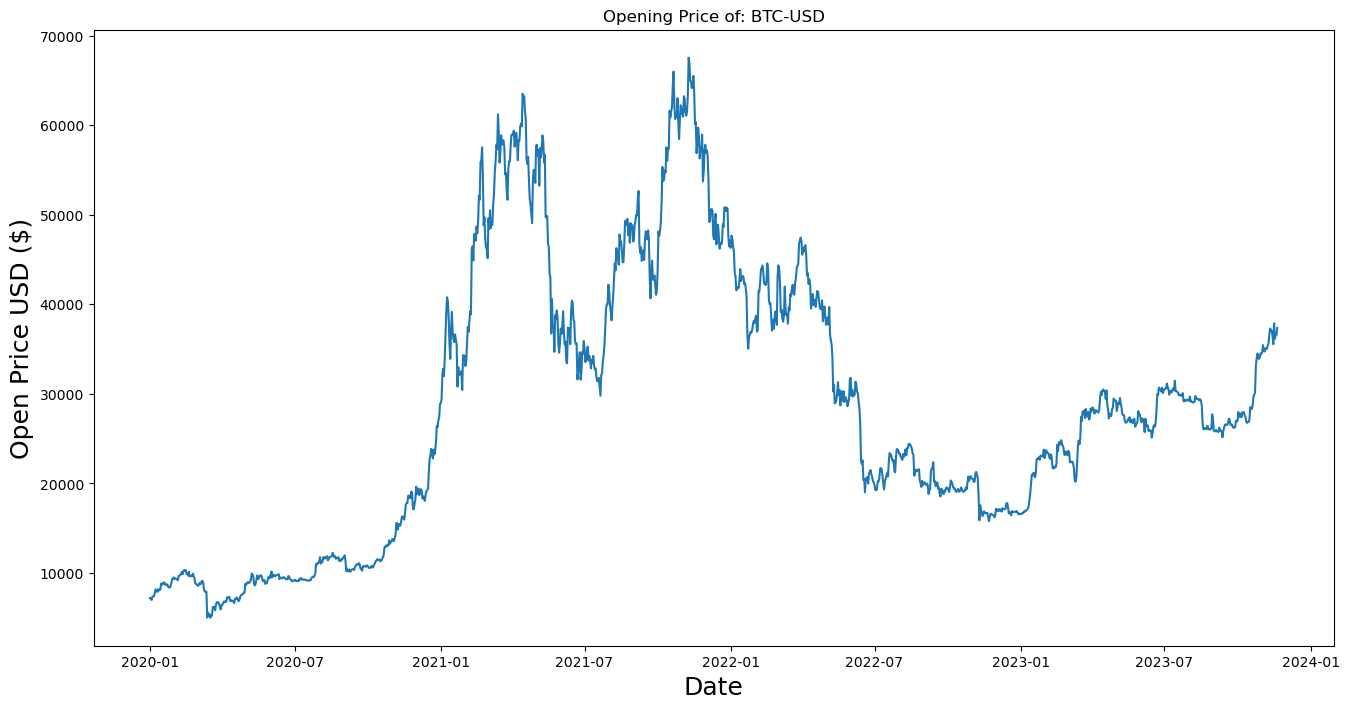

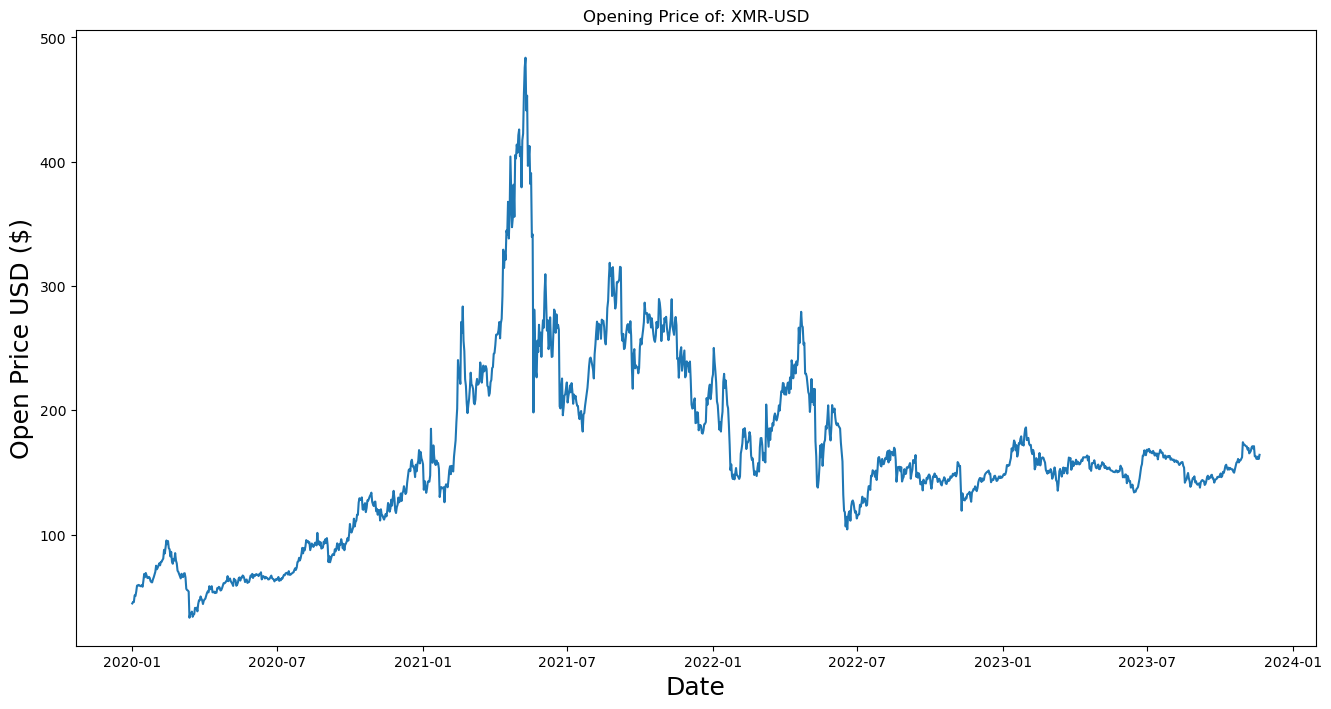

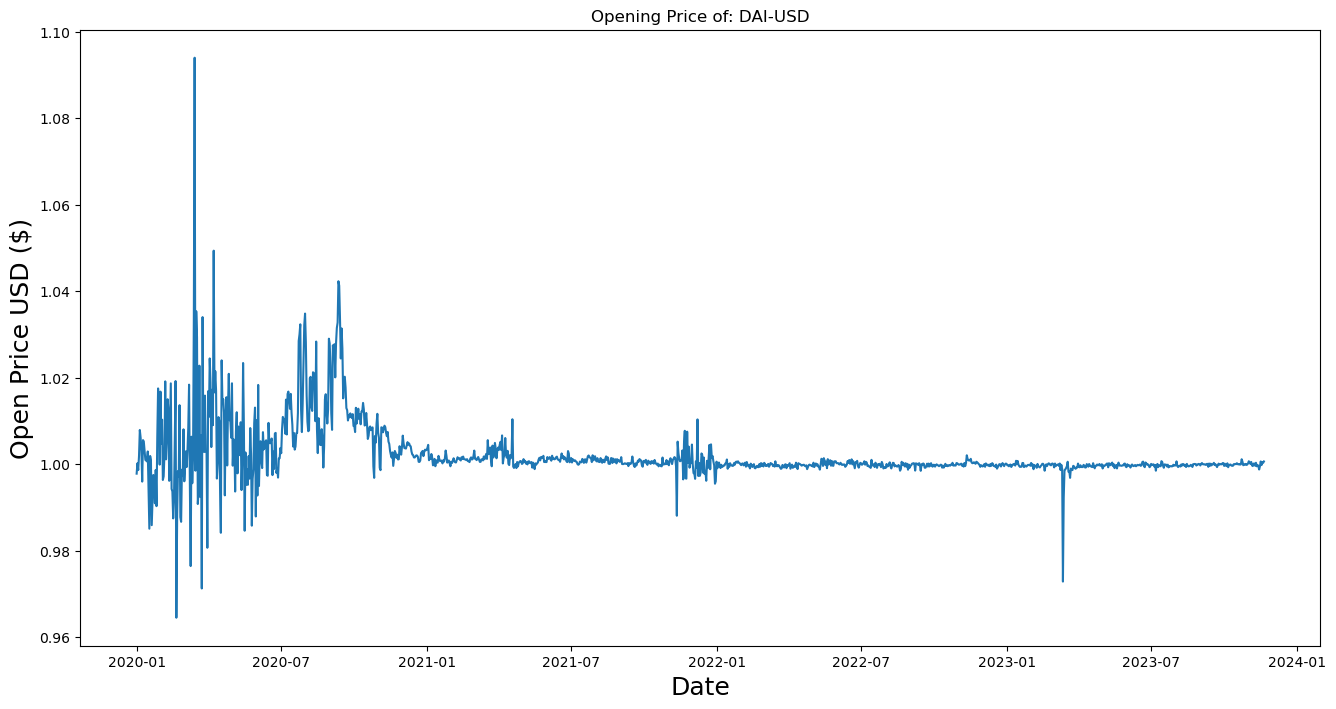

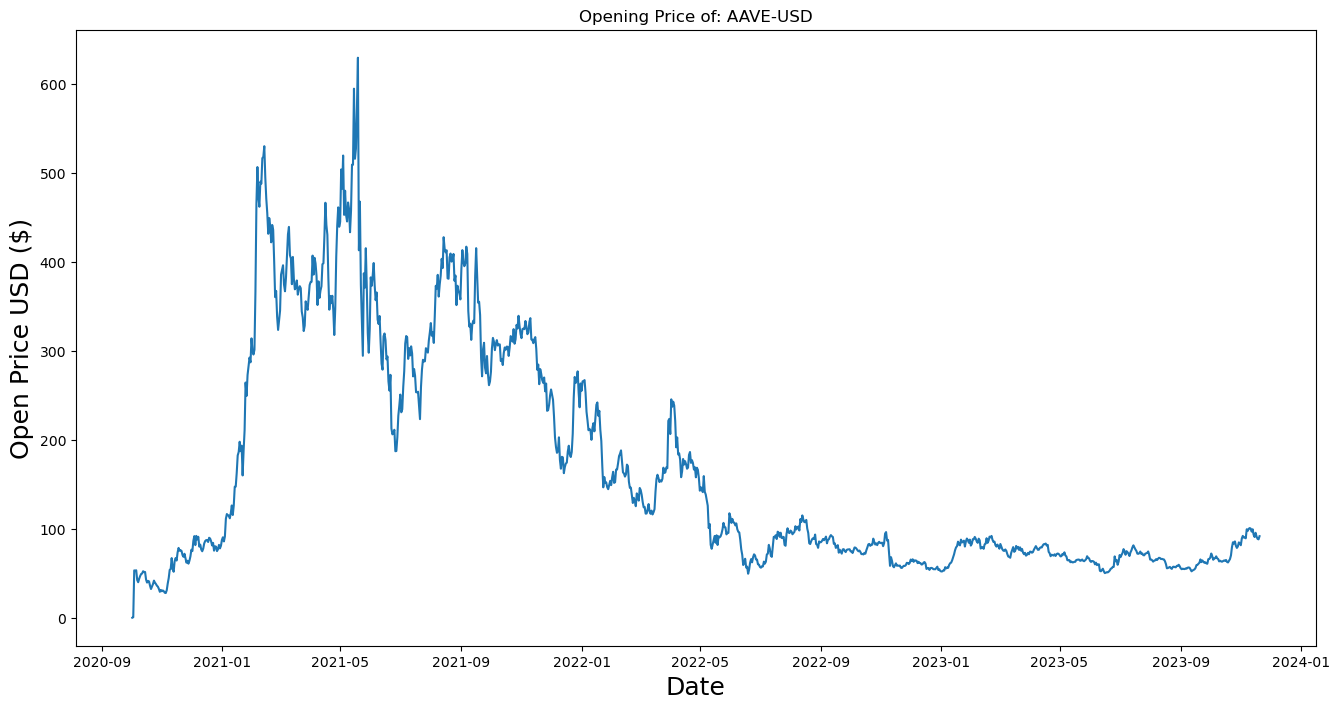

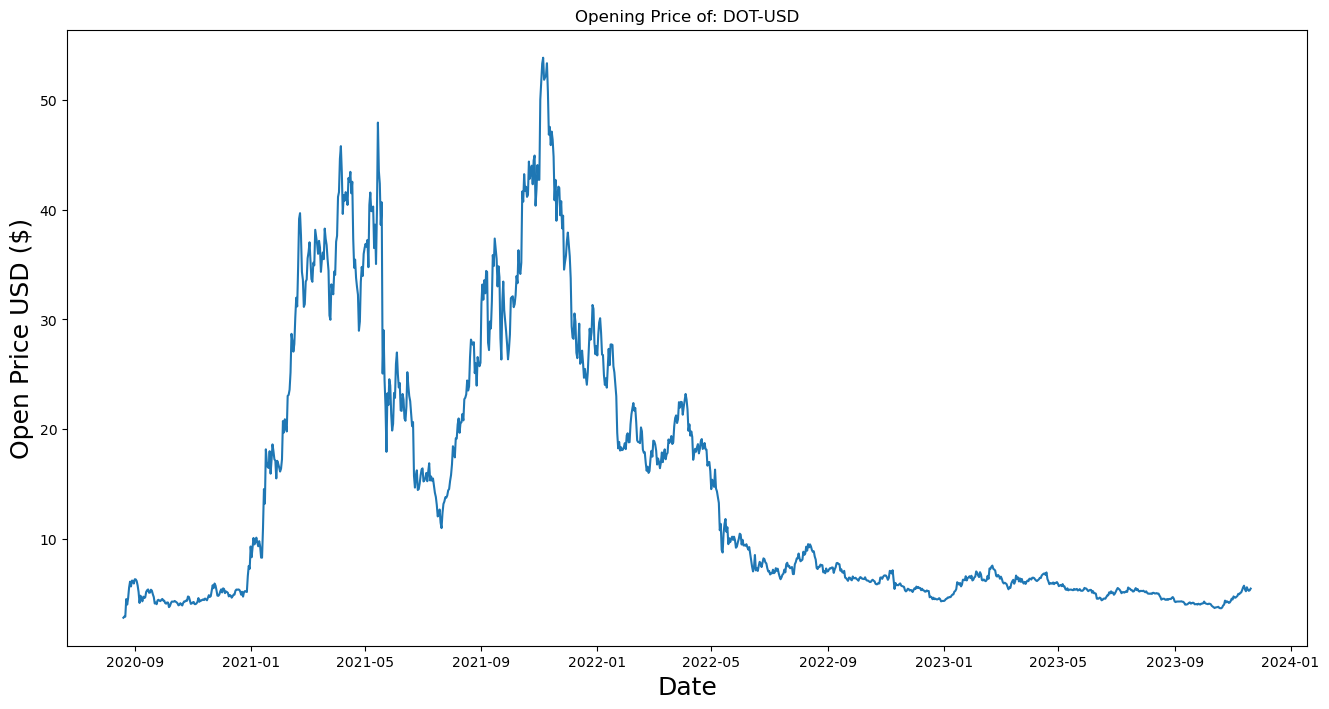

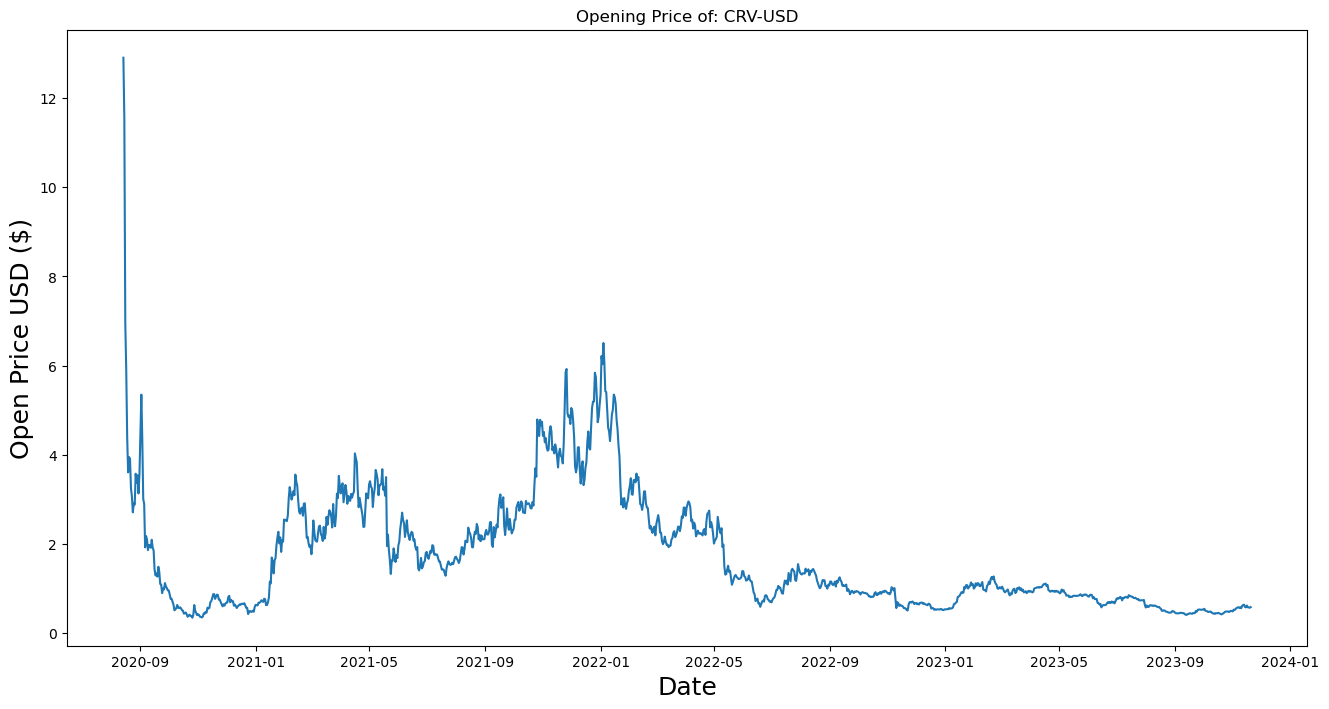

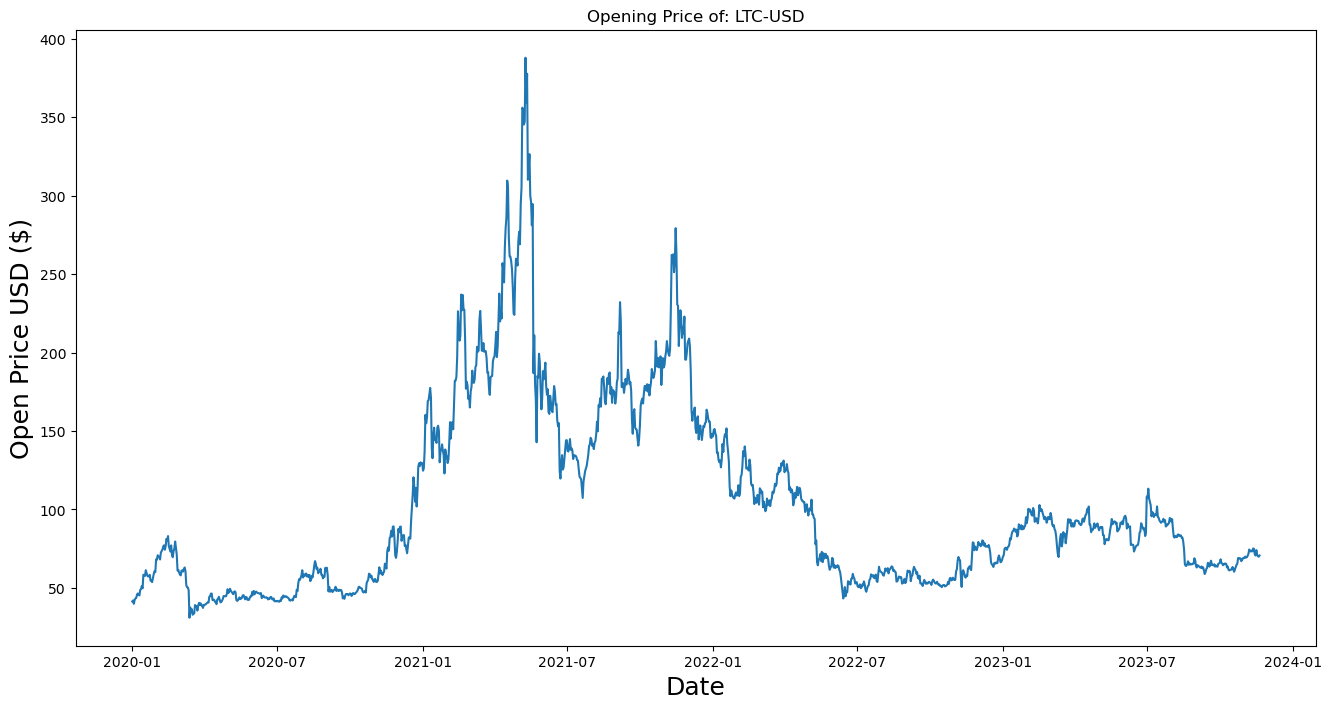

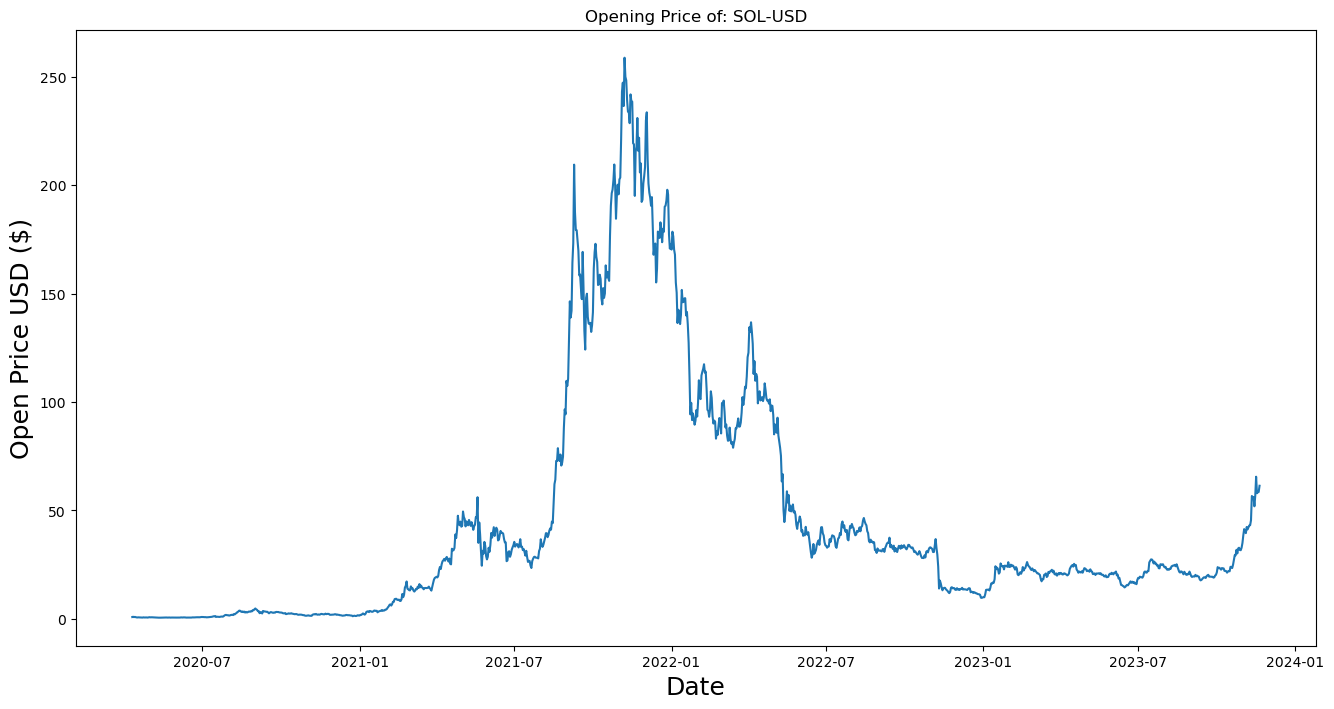

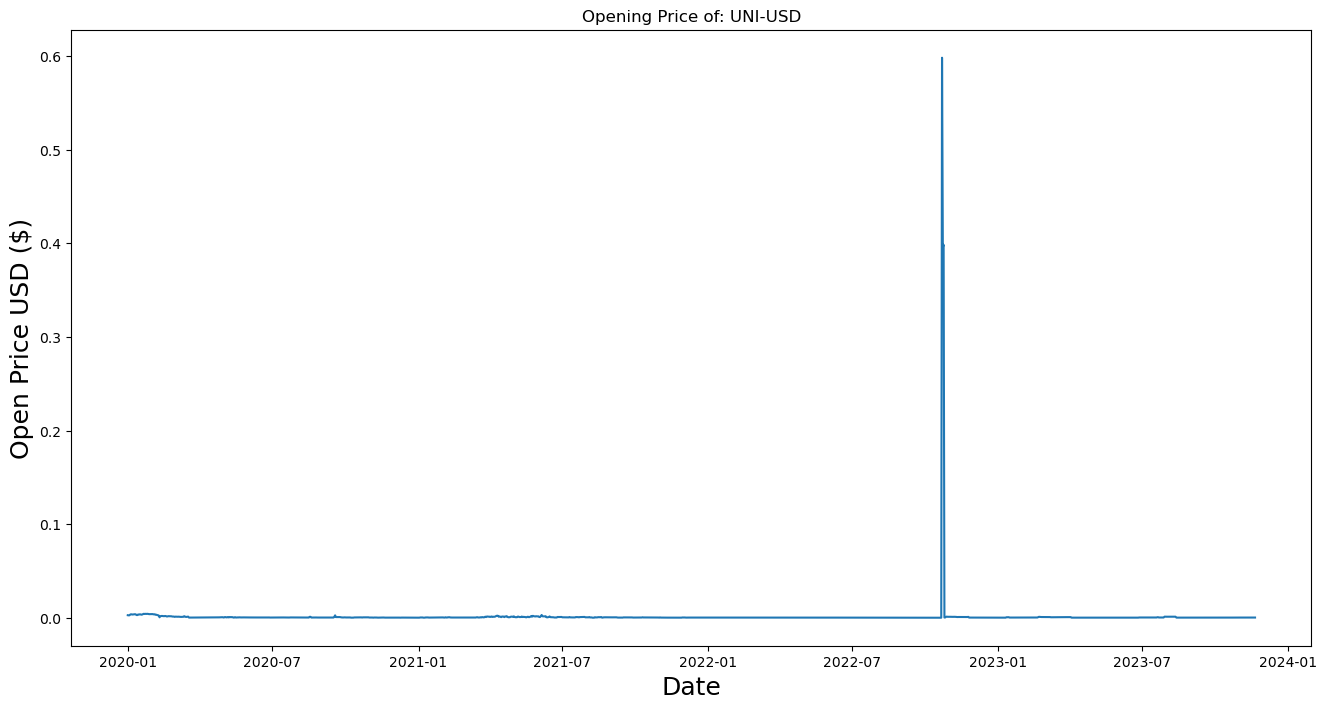

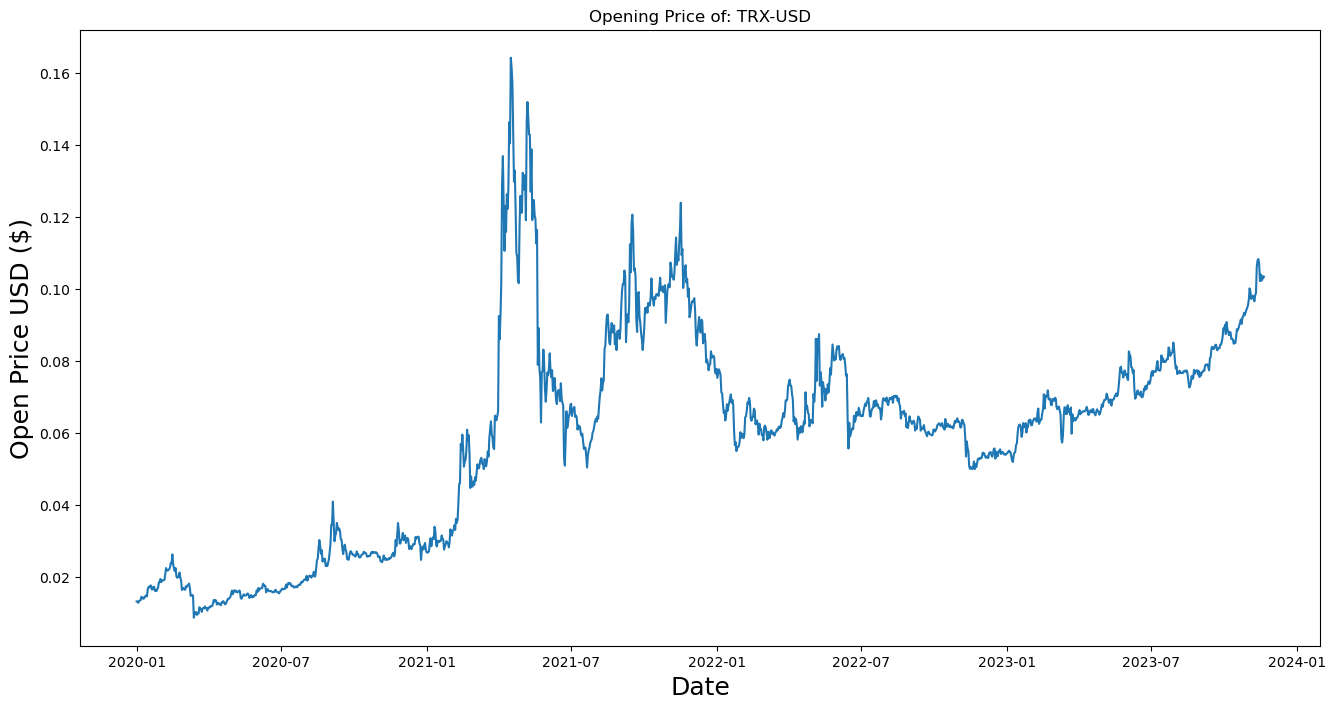

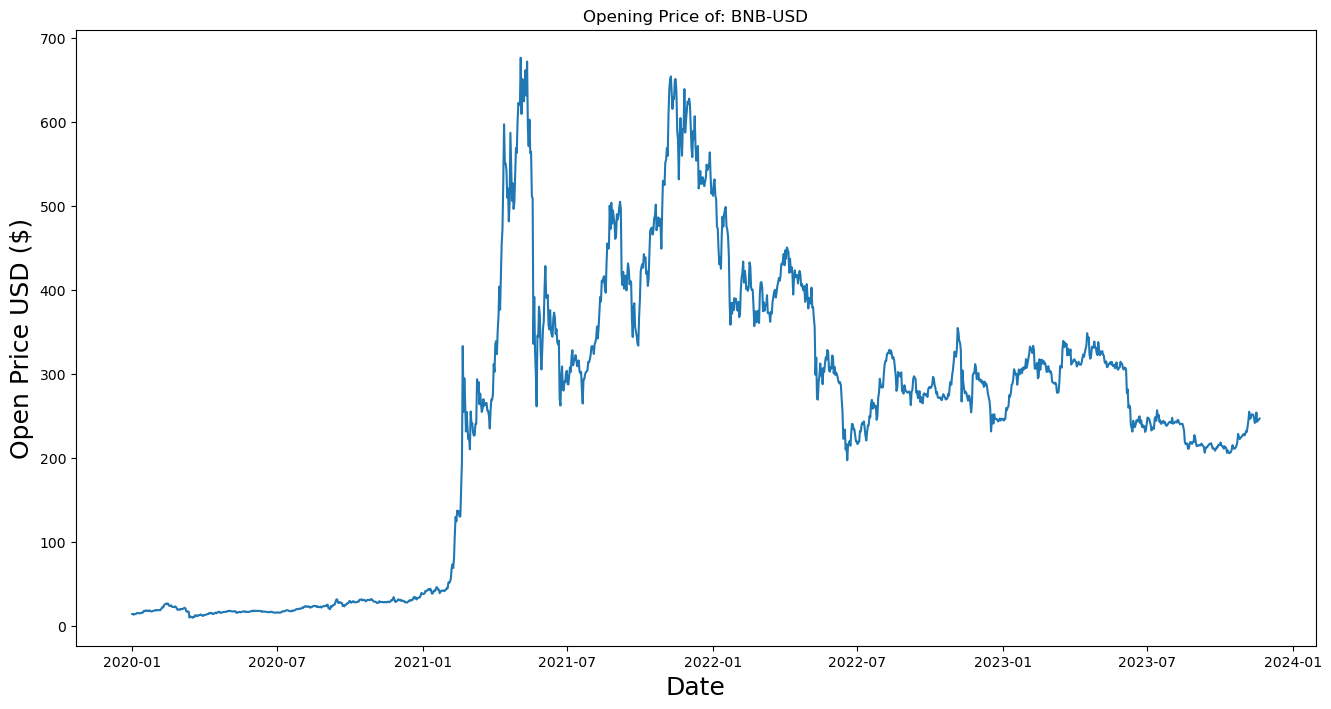

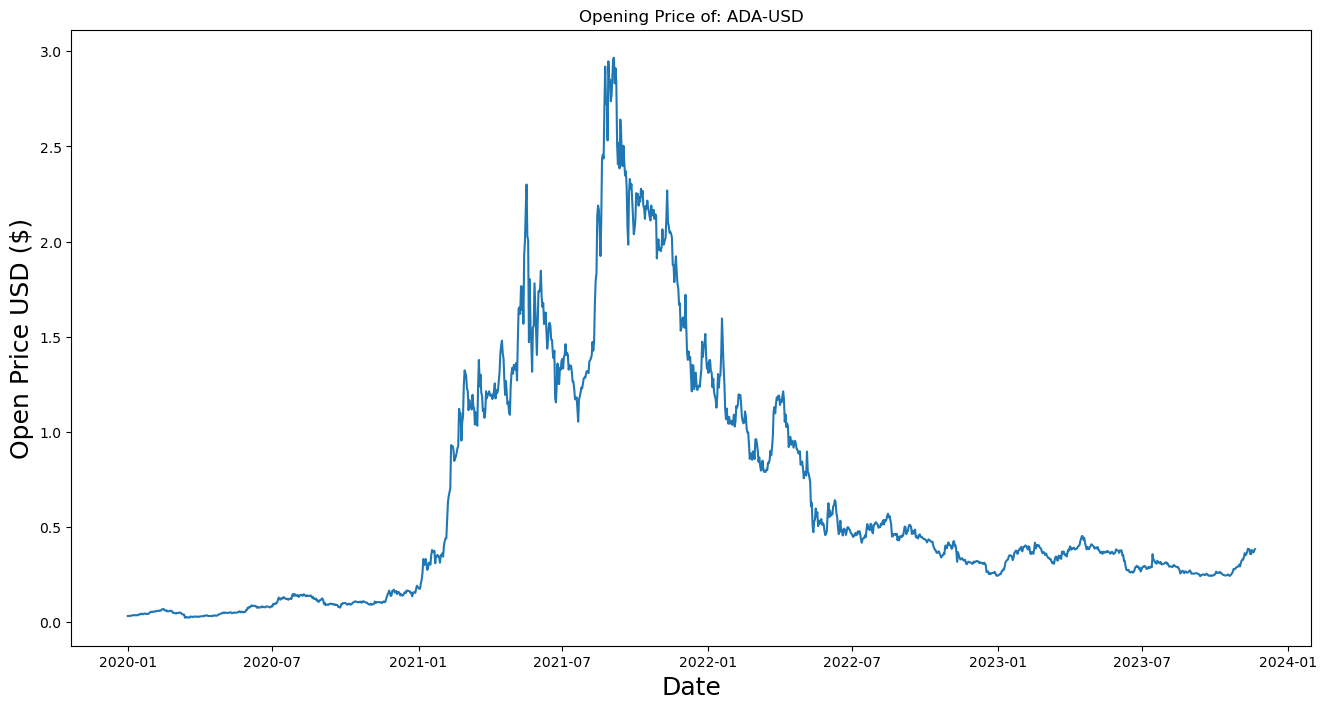

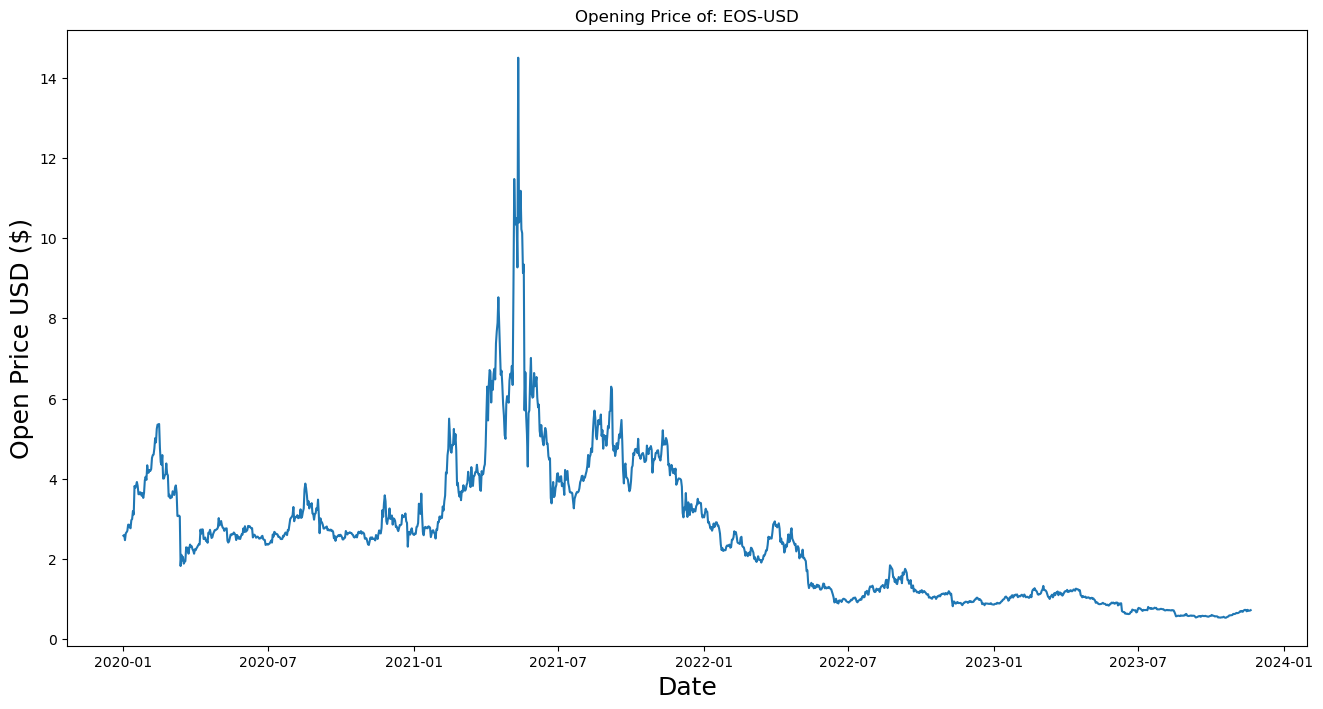

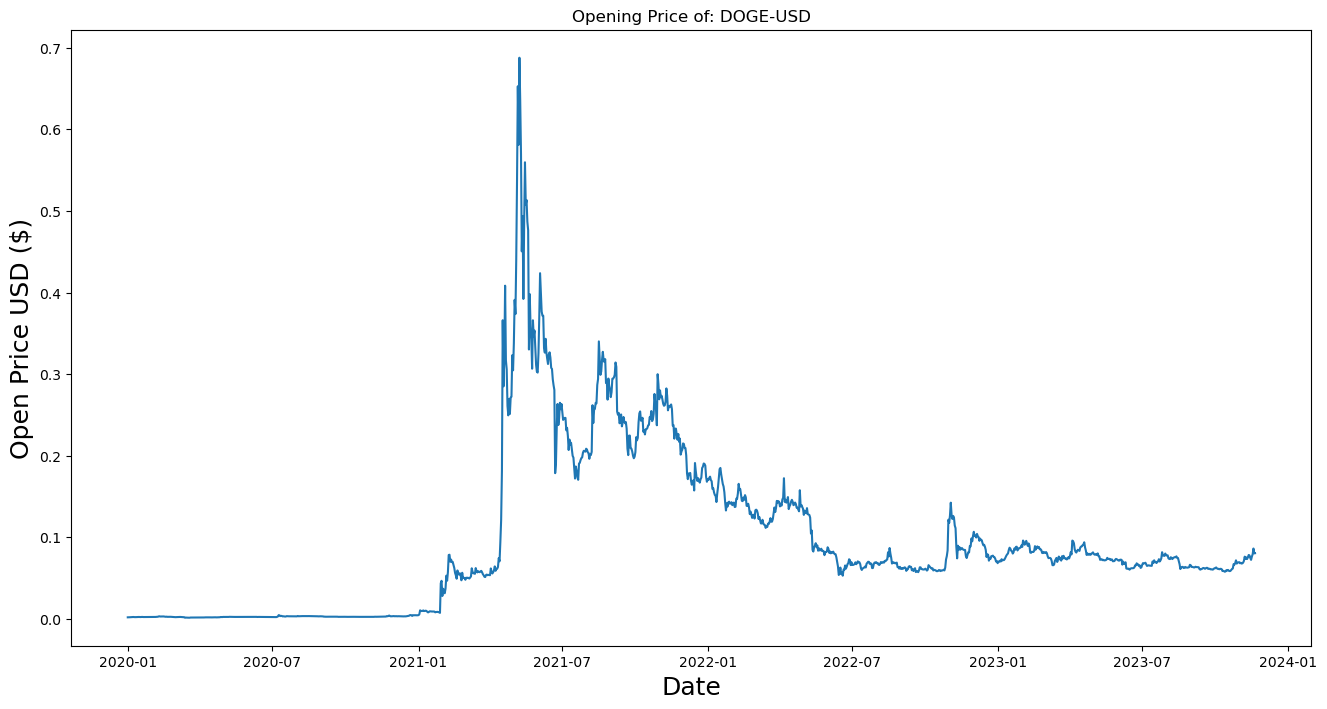

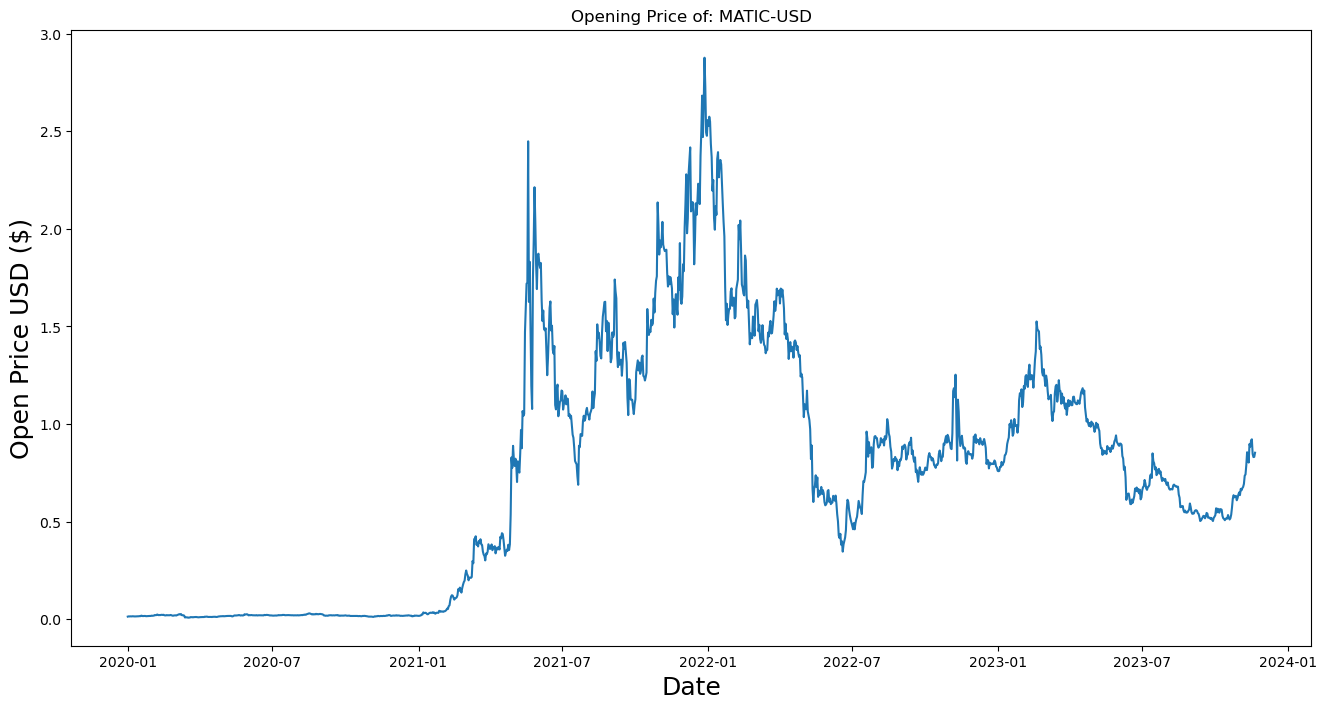

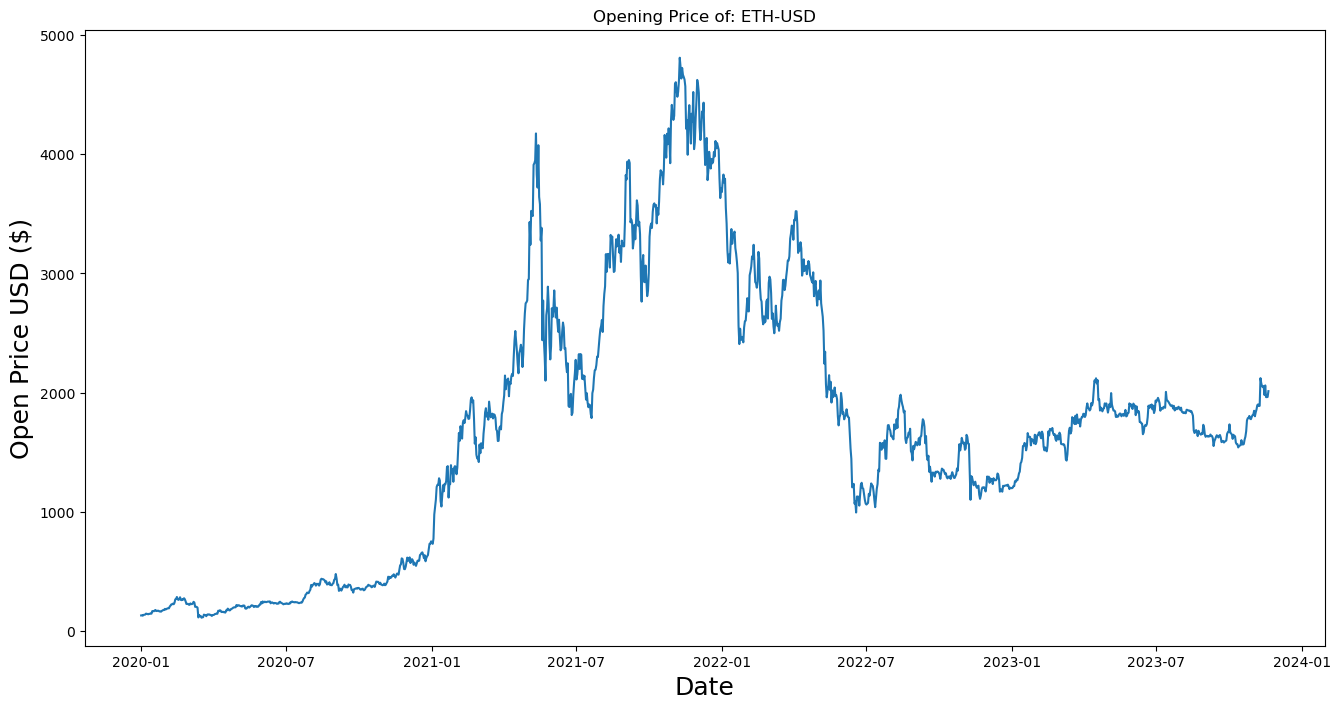

In [87]:
for i in range(len(all_data)):
    df = all_data[i]
    ticker = tickers[i]

    plt.figure(figsize=(16,8))
    plt.title('Opening Price of: '+ticker)
    plt.plot(df['Open'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Open Price USD ($)', fontsize=18)
    plt.show()

In [98]:
class DataProcessor:
    def __init__(self, tickers, all_data):
        self.tickers = tickers
        self.all_data = all_data
        self.data = self.all_data[0]
    
    def preprocess_data(self):
        # Extract 'Open' column from the DataFrame
        data = self.data.filter(['Open'])

        # Convert to np array
        dataset = data.values

        # Calculate training data length (80%)
        training_data_len = math.ceil(len(dataset) * 0.8)

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        # Create training dataset
        train_data = scaled_data[0:training_data_len, :]

        # Split the data into x_train and y_train datasets
        x_train = []
        y_train = []

        for i in range(60, len(train_data)):
            x_train.append(train_data[i - 60:i, 0])
            y_train.append(train_data[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)

        # Reshape the data into 3 dimensions
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        return x_train, y_train, scaler, scaled_data, training_data_len

data_processor = DataProcessor(tickers, all_data)
x_train, y_train, scaler, scaled_data, training_data_len = data_processor.preprocess_data()
print(x_train.shape)
print(y_train.shape)
print(scaled_data)


(1076, 60, 1)
(1076,)
[[0.03505058]
 [0.03517303]
 [0.0316857 ]
 ...
 [0.50558322]
 [0.50495002]
 [0.51755344]]


# Training the model

Epoch 1/3
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0039
Epoch 2/3
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0015
Epoch 3/3
9/9 [==============================] - 0s 5ms/step
RMSE: 795.3264125770246


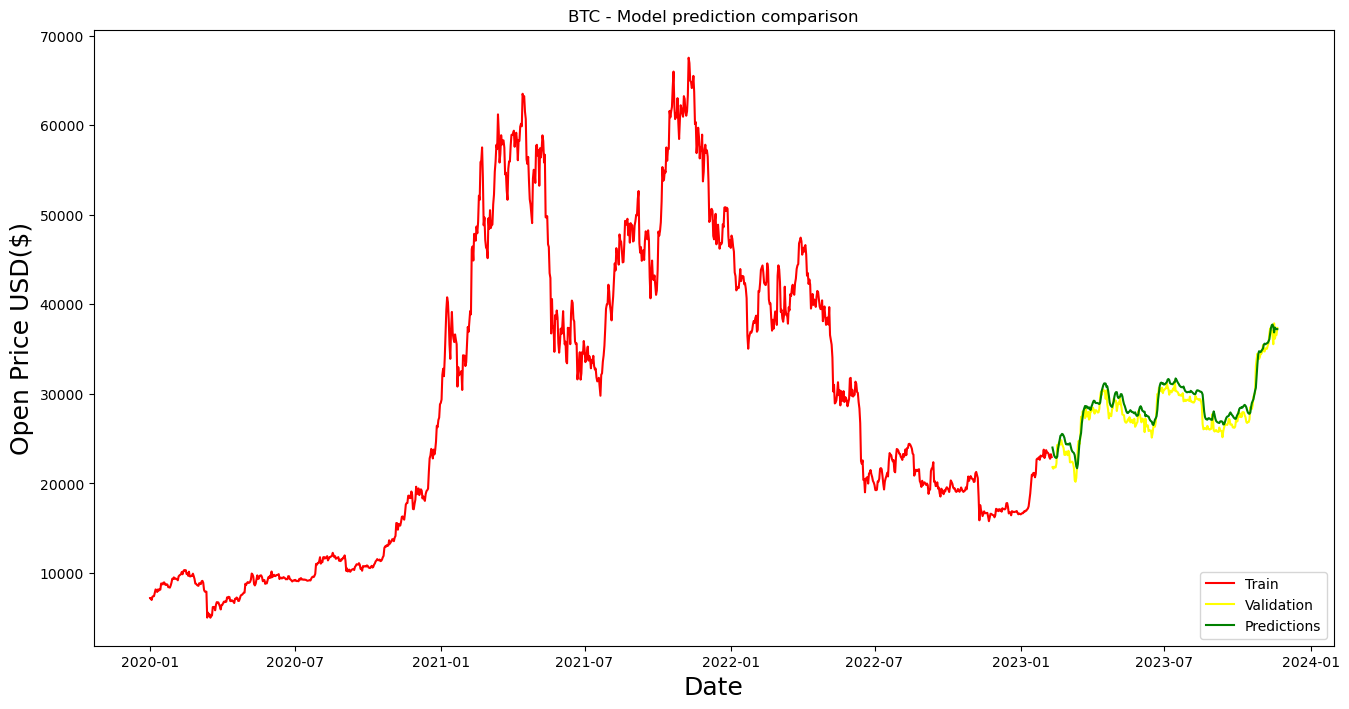

In [103]:
class LSTMModel:
    def __init__(self, x_train, y_train, scaler):
        self.x_train = x_train
        self.y_train = y_train
        self.scaler = scaler

    def build_and_train_model(self):
        # Build LSTM model
        model = Sequential()
        # Add first layer to model
        model.add(LSTM(50, return_sequences=True, input_shape=(self.x_train.shape[1], 1)))
        # Add second layer to model
        model.add(LSTM(50, return_sequences=False))
        # Add Dense Layer to model with 25 neurons
        model.add(Dense(25))
        # Add Dense Layer to model with 1 neuron
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(self.x_train, self.y_train, batch_size=1, epochs=3)
        return model

    def predict_and_evaluate(self, scaled_data, training_data_len):
        # Create the test data set
        test_data = scaled_data[training_data_len-60:, :]

        # Create the data sets x_test and y_test
        x_test = []
        y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        # Get the model's predicted price values
        predictions = self.model.predict(x_test)
        predictions = self.scaler.inverse_transform(predictions)

        # Calculate root mean squared error (RMSE)
        rmse = np.sqrt(np.mean(predictions - y_test)**2)
        return predictions, rmse

    def plot_results(self, data, predictions, training_data_len):
        train = data[:training_data_len]
        valid = data[training_data_len:]
        valid['predictions'] = predictions

        # Visualize the data
        plt.figure(figsize=(16, 8))
        plt.title('BTC - Model prediction comparison')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Open Price USD($)', fontsize=18)
        plt.plot(train['Open'], color='red')
        plt.plot(valid['Open'], color='yellow')
        plt.plot(valid['predictions'], color='green')
        plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
        plt.show()
        return valid
    
lstm_model = LSTMModel(x_train, y_train, scaler)
lstm_model.model = lstm_model.build_and_train_model()

predictions, rmse = lstm_model.predict_and_evaluate(scaled_data, training_data_len)
print("RMSE:", rmse)

valid = lstm_model.plot_results(data, predictions, training_data_len)


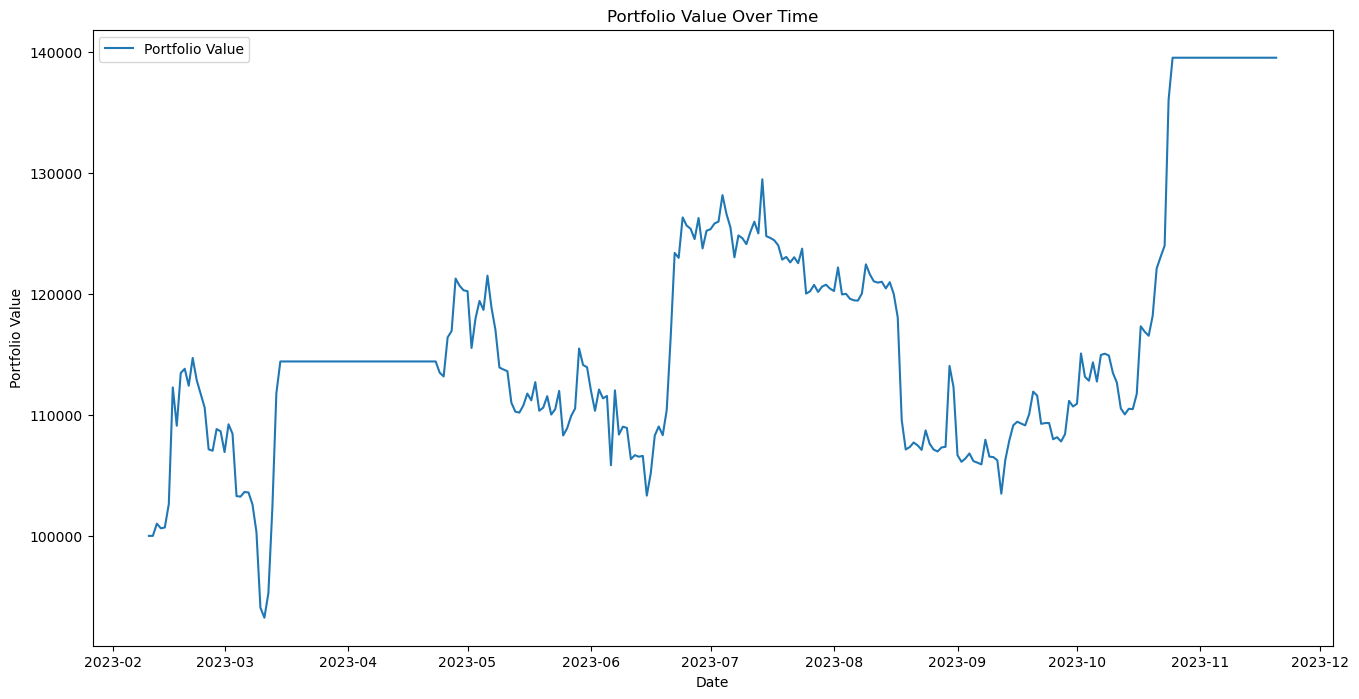

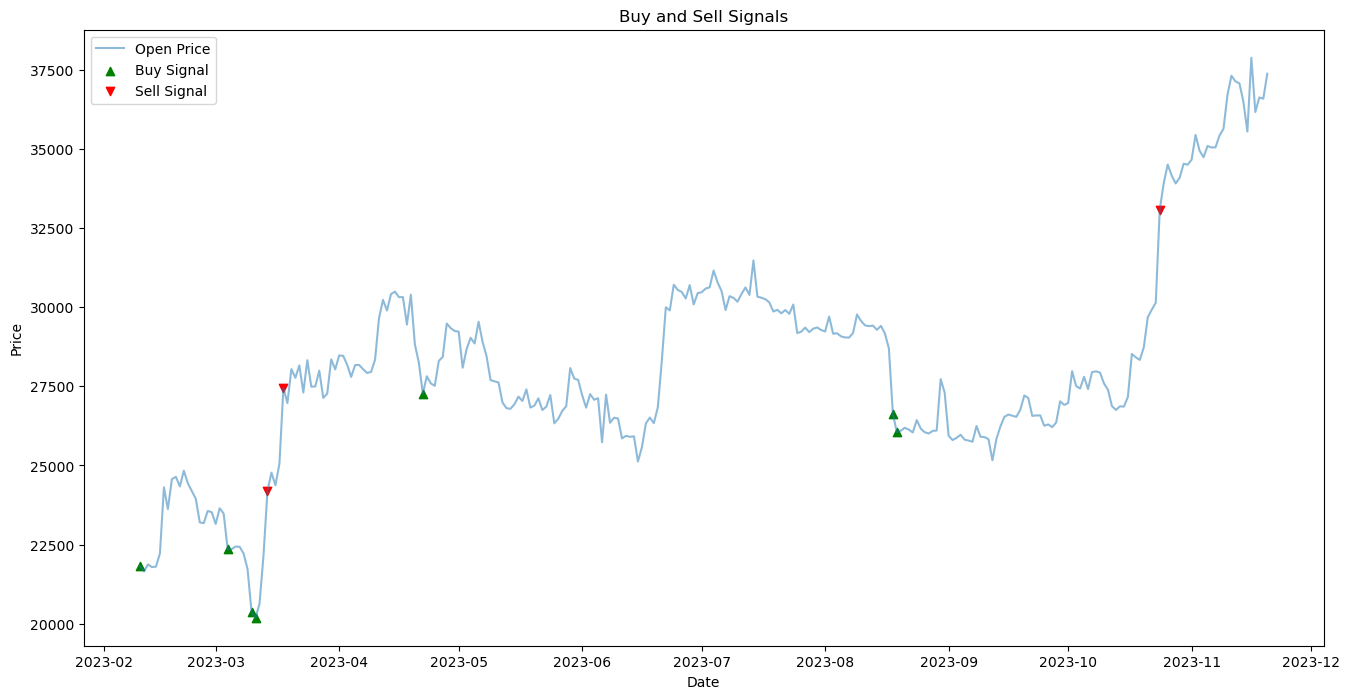

Risk Metrics:
Volatility: 0.019527275378782197
Sharpe_Ratio: -0.9543659826200492
Max_Drawdown: -0.2006074195083517
Total_Return: 39.49403455533835


In [114]:
class PortfolioManager:
    def __init__(self, valid, initial_capital=100000):
        self.valid = valid
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.quantity = 0
        self.valid['Portfolio_Value'] = initial_capital

    def generate_signals(self, buy_threshold, sell_threshold):
        self.valid['Predicted_Open'] = self.valid['predictions']
        self.valid['Predicted_Percent_Change'] = (self.valid['Predicted_Open'] - self.valid['Open']) / self.valid['Open']
        self.valid['Signal'] = 0
        self.valid.loc[self.valid['Predicted_Percent_Change'] > buy_threshold, 'Signal'] = 1  # Buy signal
        self.valid.loc[self.valid['Predicted_Percent_Change'] < sell_threshold, 'Signal'] = -1  # Sell signal

    def manage_portfolio(self):
        for i in range(1, len(self.valid)):
            if self.valid['Signal'].iloc[i-1] == 1 and self.capital > 0:
                self.quantity = self.capital / self.valid['Open'].iloc[i]
                self.capital = 0
                self.valid['Portfolio_Value'].iloc[i] = self.quantity * self.valid['Open'].iloc[i]
            elif self.valid['Signal'].iloc[i-1] == -1 and self.quantity > 0:
                self.capital = self.quantity * self.valid['Open'].iloc[i]
                self.quantity = 0
                self.valid['Portfolio_Value'].iloc[i] = self.capital
            elif self.quantity > 0:
                self.valid['Portfolio_Value'].iloc[i] = self.quantity * self.valid['Open'].iloc[i]
            else:
                self.valid['Portfolio_Value'].iloc[i] = self.capital

    def calculate_returns(self):
        self.valid['Daily_Return'] = self.valid['Portfolio_Value'].pct_change()
        self.valid['Cumulative_Return'] = (1 + self.valid['Daily_Return'].fillna(0)).cumprod() - 1

    def plot_portfolio_value(self):
        plt.figure(figsize=(16, 8))
        plt.plot(self.valid.index, self.valid['Portfolio_Value'], label='Portfolio Value')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.show()

    def plot_signals(self):
        plt.figure(figsize=(16, 8))
        plt.plot(self.valid.index, self.valid['Open'], label='Open Price', alpha=0.5)
        plt.scatter(self.valid[self.valid['Signal'] == 1].index, self.valid[self.valid['Signal'] == 1]['Open'],
                    label='Buy Signal', marker='^', color='green', alpha=1)
        plt.scatter(self.valid[self.valid['Signal'] == -1].index, self.valid[self.valid['Signal'] == -1]['Open'],
                    label='Sell Signal', marker='v', color='red', alpha=1)
        plt.title('Buy and Sell Signals')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
        
    def calculate_risk_metrics(self, risk_free_rate=-0.06):
        # Volatility (standard deviation of daily returns)
        daily_returns = self.valid['Daily_Return'].dropna()
        volatility = daily_returns.std()

        # Sharpe Ratio
        excess_return = daily_returns.mean() - risk_free_rate
        sharpe_ratio = excess_return / volatility

        # Maximum Drawdown
        cum_returns = self.valid['Portfolio_Value']
        max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()

        # Beta and Alpha (requires market returns data)
        # For beta and alpha calculation, you'll need market returns data to compare with portfolio returns.
        # You can use regression analysis to calculate beta and alpha.

        # Total Return
        total_return = (self.valid['Portfolio_Value'].iloc[-1] / self.initial_capital - 1) * 100

        return {
            'Volatility': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Total_Return': total_return,
            # 'Beta': beta,
            # 'Alpha': alpha
        }

    def print_risk_metrics(self, risk_free_rate=0.0):
        risk_metrics = self.calculate_risk_metrics(risk_free_rate)
        print("Risk Metrics:")
        for metric, value in risk_metrics.items():
            print(f"{metric}: {value}")

# Create PortfolioManager instance and manage portfolio
portfolio_manager = PortfolioManager(valid, initial_capital=100000)
buy_threshold = 0.09
sell_threshold = -0.06
portfolio_manager.generate_signals(buy_threshold, sell_threshold)
portfolio_manager.manage_portfolio()
portfolio_manager.calculate_returns()
portfolio_manager.plot_portfolio_value()
portfolio_manager.plot_signals()
portfolio_manager.calculate_risk_metrics(risk_free_rate=0.02)  # Adjust the risk-free rate as needed
portfolio_manager.print_risk_metrics(risk_free_rate=0.02)

In [107]:
tickers

['BTC-USD',
 'XMR-USD',
 'DAI-USD',
 'AAVE-USD',
 'DOT-USD',
 'CRV-USD',
 'LTC-USD',
 'SOL-USD',
 'UNI-USD',
 'TRX-USD',
 'BNB-USD',
 'ADA-USD',
 'EOS-USD',
 'DOGE-USD',
 'MATIC-USD',
 'ETH-USD']

In [109]:
#Get the quote
stock_quote = yf.download(tickers[0], start="2020-01-01", interval='1d')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Opening Price of ETH-USD tomorrow:[[37242.273]]
